## QF607 Numerical Methods - Assignment 2
### Anirban Chakraborty; 01436632; anirbanc.2021@mqf.smu.edu.sg

In [1]:
import math
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import CubicSpline
from scipy import optimize
import bisect

#### Exercise 1.

Implement a trinomial tree that takes the below signature:

Instead of taking the parameter $\lambda$ in our example code, this function takes a discontinuity K and anchors a tree node to K by tuning $\lambda$ inside the pricer.
Note that there are many ways to adjust $\lambda$, one example is to construct the tree with $\lambda = \sqrt{3}$ first, find the node closest to $K$, then adjust $\lambda$ such that the node falls on $K$, but you are free to define your own way to achieve this.

Plot the pricing errors of this trinomial tree pricer with the market and strike below, for number of tree steps from 10 to 300 (similar to our binomial tree test cases).
Use a European Call option and a Binary Call option as test trades.

In [2]:
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'
    BinaryCall = 'BinaryCall'
    BinaryPut = 'BinaryPut'

class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        elif self.payoffType == PayoffType.BinaryCall:
            if S > self.strike:
                return 1.0
            else:
                return 0.0
        elif self.payoffType == PayoffType.BinaryPut:
            if S < self.strike:
                return 1.0
            else:
                return 0.0
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation

def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def bsPrice(S, r, vol, T, strike, payoffType):
    fwd = S * math.exp(r * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    elif payoffType == PayoffType.BinaryCall:
        return math.exp(-r * T) * cnorm(d2)
    elif payoffType == PayoffType.BinaryPut:
        return math.exp(-r * T) * cnorm(-d2)
    else:
        raise Exception("not supported payoff type", payoffType)

In [3]:
#Calibrate node to discontinuity function
def Cal_lmda(vol, t, S, n, K, lmda_i=np.sqrt(3)):
    #Use intial assumption of lambda and check last nodes of tree, vsi
    u_i = np.exp(lmda_i * vol * np.sqrt(t))
    vs_i = [S * u_i ** (n - i) for i in range(2*n + 1)]
    #Calculate nearest node to discontinuity and its index
    K_Index = (np.abs(np.array(vs_i) - K)).argmin()
    #Back-calculate lambda setting node at K.
    if (n - K_Index)==0:
        return lmda_i
        #raise Exception("K and S too close, calibration of lamda not possible")
    else:
        return 1/((n - K_Index)*vol*np.sqrt(t))*np.log(K/S)

In [4]:
def trinomialPricerAnchor(S, r, q, vol, trade, n, K):
    t = trade.expiry / n
    #Calibrate lambda using function
    lmda = Cal_lmda(vol, t, S, n, K, np.sqrt(3))
    u = np.exp(lmda * vol * np.sqrt(t))
    mu = r - q
    pu = 1/(2*lmda**2) + (mu - vol**2/2)/(2*lmda*vol) * np.sqrt(t)
    pd = 1/(2*lmda**2) - (mu - vol**2/2)/(2*lmda*vol) * np.sqrt(t)
    pm = 1 - pu - pd
    vs = [trade.payoff(S * u ** (n - i)) for i in range(2*n + 1)]
    for i in range(n - 1, -1, -1):
        for j in range(2*i + 1):
            nodeS = S * u ** (i - j)
            continuation = np.exp(-r * t) * (vs[j] * pu +  + vs[j+1] * pm + vs[j+2] * pd)
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

In [5]:
trade = EuropeanOption(1, 105, PayoffType.Call)
n = 300
K = 105
S, r, q, vol = 100, 0.01, 0, 0.2

In [6]:
trinomialPricerAnchor(S, r, q, vol, trade, n, K)

6.285869924740849

In [7]:
def testTrinomial():
    S, r, q, vol = 100, 0.01, 0, 0.2
    n, K = 300, 105
    opt1 = EuropeanOption(1, 105, PayoffType.Call)
    opt2 = EuropeanOption(1, 105, PayoffType.BinaryCall)
    bsprc1 = bsPrice(S, r, vol, opt1.expiry, opt1.strike, opt1.payoffType)
    bsprc2 = bsPrice(S, r, vol, opt2.expiry, opt2.strike, opt2.payoffType)
    prc1 = trinomialPricerAnchor(S, r, q, vol, opt1, n, K)
    prc2 = trinomialPricerAnchor(S, r, q, vol, opt2, n, K)
    print("Black Scholes Vanilla Call Price = ", bsprc1)    
    print("Trinomial Tree Vanilla Call Price = ", prc1)
    print("Black Scholes Binary Call Price = ", bsprc2)    
    print("Trinomial Tree Binary Call Price = ", prc2)
    Opt1_Err = [math.log(abs(trinomialPricerAnchor(S, r, q, vol, opt1, i, K) - bsprc1)) for i in range(1, n)]
    Opt2_Err = [math.log(abs(trinomialPricerAnchor(S, r, q, vol, opt2, i, K) - bsprc2)) for i in range(1, n)]
    plt.figure(figsize =(16,8))
    plt.plot(range(1, n), Opt1_Err, label="European Call")
    plt.plot(range(1, n), Opt2_Err, label="Binary Call")
    plt.title("Trinomial Tree Logarithmic Pricing Error")
    plt.xlabel("Number of Steps")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

Black Scholes Vanilla Call Price =  6.297254539086019
Trinomial Tree Vanilla Call Price =  6.285869924740849
Black Scholes Binary Call Price =  0.3805729201694937
Trinomial Tree Binary Call Price =  0.40374105797437015


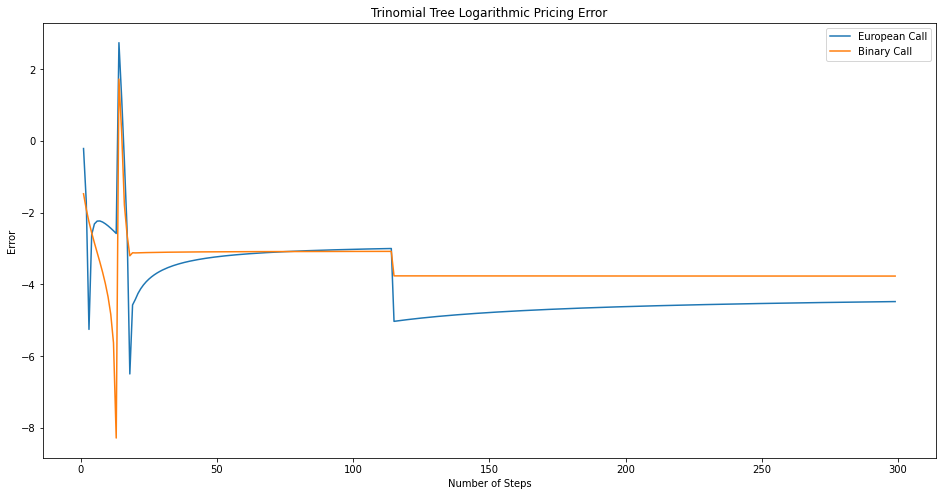

In [8]:
testTrinomial()

#### Exercise 2.

Assuming forward delta convention, implement below function ```strikeFromdelta``` that calculates the strike from a given delta.
You may use the ```fwdDelta``` function below.

In [9]:
class PayoffType(Enum):
    Call = 0
    Put = 1

def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def fwdDelta(fwd, stdev, strike, payoffType):
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    elif payoffType == PayoffType.Put:
        return -cnorm(-d1)
    else:
        raise Exception("not supported payoff type", payoffType)

def strikeFromDelta(S, r, q, T, vol, delta, payoffType):
    fwd = S*np.exp((r-q)*T)
    strike = 0
    if payoffType == PayoffType.Put:
        delta = -1 * delta
    f = lambda strike: (fwdDelta(fwd, vol, strike, payoffType) - delta)
    strike_l, strike_h = 0.01, S*10
    return optimize.brentq(f, strike_l, strike_h)

In [10]:
S, r, q, T, vol, delta, payoffType = 100, 0.01, 0, 1, 0.2, 0.25, PayoffType.Call
strikeFromDelta(S, r, q, T, vol, delta, payoffType)

117.92727678308832

In [11]:
S, r, q, T, vol = 100, 0.01, 0, 1, 0.2
calldeltas = np.arange(0.05,1,0.05)
putdeltas = np.arange(0.05,1,0.05)

call_strikes = [strikeFromDelta(S, r, q, T, vol, i, PayoffType.Call) for i in calldeltas]
put_strikes = [strikeFromDelta(S, r, q, T, vol, i, PayoffType.Put) for i in putdeltas]

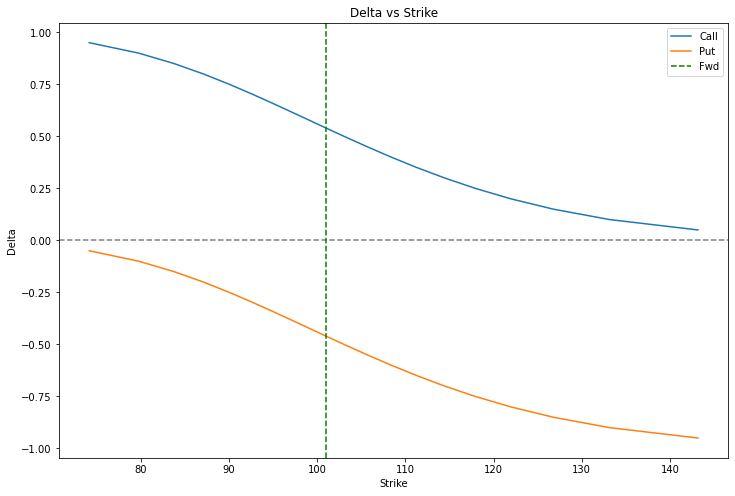

In [12]:
plt.figure(figsize = (12,8))
plt.plot(call_strikes, calldeltas, label = "Call")
plt.plot(put_strikes, -putdeltas, label = "Put")
plt.axhline(y=0, color='gray', linestyle='--')
plt.axvline(x=S*np.exp((r-q)*T), color='g', linestyle='--', label = "Fwd")
plt.title("Delta vs Strike")
plt.xlabel("Strike")
plt.ylabel("Delta")
plt.legend()
plt.show()

#### Exercise 3.

Implement ```smilefromMarks``` function below, it take the time to maturity $T$, current stop price $S$, risk free and dividend rate $r$ and $q$,
ATM volatility, BF25, RR25, BF10, RR10 quotes, returns a CubicSpline interpolated smile for this pillar. We assume ATM forward convention. 
You may use the Smile class provided below.   

In [13]:
class Smile:
    def __init__(self, strikes, vols):
        # add additional point on the right to avoid arbitrage
        self.strikes = strikes  + [1.1*strikes[-1] - 0.1*strikes[-2]]
        self.vols = vols + [vols[-1] + (vols[-1]-vols[-2])/10]
        self.cs = CubicSpline(strikes, vols, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)
    def Vol(self, k):
        if k < self.strikes[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        else:
            return self.cs(k)

def smileFromMarks(T, S, r, q, atmvol, bf25, rr25, bf10, rr10):
    call25vol = (2*(bf25+atmvol) + rr25)/2
    put25vol = (2*(bf25+atmvol) - rr25)/2
    call10vol = (2*(bf10+atmvol) + rr10)/2
    put10vol = (2*(bf10+atmvol) - rr10)/2
    
    call25strike =  strikeFromDelta(S, r, q, T, call25vol, 0.25, PayoffType.Call)
    put25strike =  strikeFromDelta(S, r, q, T, put25vol, 0.25, PayoffType.Put)
    call10strike =  strikeFromDelta(S, r, q, T, call10vol, 0.1, PayoffType.Call)
    put10strike =  strikeFromDelta(S, r, q, T, put10vol, 0.1, PayoffType.Put)

    strikes = [put10strike, put25strike, call25strike, call10strike]
    vols = [put10vol, put25vol, call25vol, call10vol]
    return Smile(strikes, vols)

With ```smileFromMarks```, we can prepare our implied volatility surface from input marks.

In [14]:
class ImpliedVol:
    def __init__(self, ts, smiles):
        self.ts = ts
        self.smiles = smiles
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k)
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k)
        else:  # in between two brackets
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return  math.sqrt((w * prevVar + (1-w) * nextVar)/t)
        return
    def dVoldK(self, t, k):
        return (self.Vol(t, k+0.01) - self.Vol(t, k-0.01)) / 0.02
    def dVoldT(self, t, k):
        return (self.Vol(t+0.005, k) - self.Vol(t, k)) / 0.005
    def dVol2dK2(self, t, k):
        return (self.Vol(t, k+0.01) + self.Vol(t, k-0.01) - 2*self.Vol(t, k)) / 0.0001

Plot the test implied volatility surface using below test functions.

In [15]:
def createTestImpliedVol(S, r, q):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5] # in year
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i], rr25s[i], bf10s[i], rr10s[i]) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

In [16]:
def plotTestImpliedVolSurface():
    S, r, q = 1.25805, 0.01, 0.003
    iv = createTestImpliedVol(S, r, q)
    tStart, tEnd = 0.02, 0.5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.05, PayoffType.Put)
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.05, PayoffType.Call)
    ks = np.arange(kmin, kmax, 0.01)

    vs = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j])
    hf = plt.figure(figsize = (12,12))
    ha = hf.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(ks, ts)
    ha.plot_surface(X, Y, vs)
    ha.set_xlabel('Strike', fontsize=15, rotation=60)
    ha.set_ylabel('Expiry', fontsize=15, rotation=60)
    ha.set_zlabel('Volatility', fontsize=15, rotation=60)
    plt.title("Volatility Surface", fontsize=25)
    plt.show()

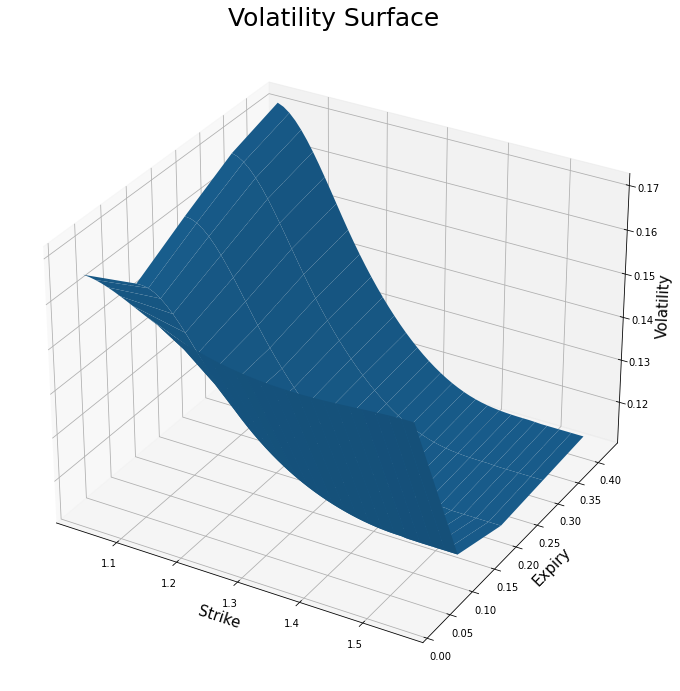

In [17]:
plotTestImpliedVolSurface()